In [1]:
# This will reconstruct the rib scans for the PCD-CT scan

import os
import numpy as np
from reconstruction.ring_corr import devon_correction
from reconstruction.find_dead_pixels import find_dead_pixels
from reconstruction.inidividual_bin_recon import correct_dead_pixels, reconstruct_CT
from scipy.signal import medfilt
from scipy.interpolate import interp1d

directory = r'\Material_decomposition_data/Calibration_and_test_data'
load_folder = '23_08_26_CT_inserts_PCD'
sub_folders = ['rib2', 'rib2_Au', 'Au_phantom']
offset = -1

thresholds = [30, 35, 50, 65, 81, 95]
recon_bins_single = [1]
recon_bins_multiple = [[3, 4]]

# VARIABLES TO CHANGE
save = True

num_angles = 720  # The number of projections
scan_duration = 180  # The length of the CT scan (s)


proj_time = scan_duration/num_angles  # The scale factor (the scan time per projection/angle)

# Load the raw flat field, dark field, and water phantom scans (only the first 5 bins, discarding the first frame)
air60 = np.load(os.path.join(directory, load_folder, 'airscan_65s', 'Data', 'data.npy'))[1:, :, :, 0:5]
air1 = np.sum(air60, axis=0) / (60 / proj_time)  # Sum all frames to get the full 60s flat field scan (scaled correctly per frame)
dark = np.load(os.path.join(directory, load_folder, 'darkscan_60s', 'Data', 'data.npy'))[:, :, 0:5]
water = np.load(os.path.join(directory, load_folder, 'water', 'Data', 'data.npy'))[1:, :, :, 0:5]
water = np.sum(water, axis=0)  # Sum all frames

# Go through each sub folder
for sub in sub_folders:

    data = np.load(os.path.join(directory, load_folder, sub, 'Data', 'data.npy'))

     # This will cut the projections down to the correct number if there are more than necessary
    if num_angles != len(data):
        diff = abs(num_angles - len(data))
        data = data[int(np.ceil(diff / 2)):len(data) - diff // 2]

    # Process each of the individual bins
    for b in recon_bins_single:
        save_file = f'{thresholds[b]}-{thresholds[b+1]}.npy'

        os.makedirs(os.path.join(directory, load_folder, sub, 'CT'), exist_ok=True)

        # The save locations for the sinogram, CT, and normalized CT
        sino_save_path = os.path.join(directory, load_folder, sub, 'Data', save_file)
        ct_save_path = os.path.join(directory, load_folder, sub, 'CT', f'CT_{save_file}')

        print(sub, save_file)

        # Sum counts in the correct bins for all data
        bin_data = data[:, :, :, b]
        bin_air1 = air1[:, :, b]
        bin_air60 = air60[:, :, :, b]
        bin_dark = dark[:, :, b]
        bin_water = water[:, :, b]

        # Create the dead pixel mask
        dpm = find_dead_pixels(np.sum(bin_air60[0:6], axis=0), np.sum(bin_air60[6:], axis=0), bin_dark)

        # Correct raw data and air data for dead pixels
        print('Correcting dead pixels in raw data')
        bin_data = correct_dead_pixels(bin_data, dpm, True, False)
        print('Correcting dead pixels in air scan')
        bin_air1 = correct_dead_pixels(bin_air1, dpm, True, True)

        # Do the -ln(I/I0) correction
        sino = np.squeeze(np.log(bin_air1 + 0.01) - np.log(bin_data + 0.01))

        bin_air1 = np.squeeze(bin_air1)

        # Correct for pixel non-uniformities (ring artifacts)
        corr_array = devon_correction(bin_water, bin_air1 * (60 / proj_time), dpm, num_bins=1)

        # Correct the sinogram
        sino = np.multiply(corr_array, sino)

        # Additional correction
        sum_corr = np.sum(sino, axis=0)
        sum_dpm = np.ones((24, 576))
        xpts = np.arange(576)
        for z in range(24):
            f = interp1d(xpts, medfilt(sum_corr[z], 21))

            diff = np.abs(f(xpts) - sum_corr[z])

            sum_dpm[z][diff > 10] = np.nan

        sino = np.squeeze(correct_dead_pixels(sino, sum_dpm, True, False))

        # Save the sinogram and display it
        if save:
            np.save(sino_save_path, sino)

        # Now reconstruct the CT scan
         # Reconstruct the sinogram
        ct = reconstruct_CT(sino, h_offset=offset)

        # Save the CT scan
        if save:
            np.save(ct_save_path, ct)

    # Process each of the added bins
    for mult_bins in recon_bins_multiple:

        b1, b2 = mult_bins

        save_file = f'{thresholds[b1]}-{thresholds[b2+1]}.npy'

        os.makedirs(os.path.join(directory, load_folder, sub, 'CT'), exist_ok=True)

        # The save locations for the sinogram, CT, and normalized CT
        sino_save_path = os.path.join(directory, load_folder, sub, 'Data', save_file)
        ct_save_path = os.path.join(directory, load_folder, sub, 'CT', f'CT_{save_file}')

        print(sub, save_file)

        # Sum counts in the correct bins for all data
        bin_data = np.sum(data[:, :, :, b1:b2+1], axis=-1)
        bin_air1 = np.sum(air1[:, :, b1:b2+1], axis=-1)
        bin_air60 = np.sum(air60[:, :, :, b1:b2+1], axis=-1)
        bin_dark = np.sum(dark[:, :, b1:b2+1], axis=-1)
        bin_water = np.sum(water[:, :, b1:b2+1], axis=-1)

        # Create the dead pixel mask
        dpm = find_dead_pixels(np.sum(bin_air60[0:6], axis=0), np.sum(bin_air60[6:], axis=0), bin_dark)

        # Correct raw data and air data for dead pixels
        print('Correcting dead pixels in raw data')
        bin_data = correct_dead_pixels(bin_data, dpm, True, False)
        print('Correcting dead pixels in air scan')
        bin_air1 = correct_dead_pixels(bin_air1, dpm, True, True)

        # Do the -ln(I/I0) correction
        sino = np.squeeze(np.log(bin_air1 + 0.01) - np.log(bin_data + 0.01))

        bin_air1 = np.squeeze(bin_air1)

        # Correct for pixel non-uniformities (ring artifacts)
        corr_array = devon_correction(bin_water, bin_air1 * (60 / proj_time), dpm, num_bins=1)

        # Correct the sinogram
        sino = np.multiply(corr_array, sino)

        # Additional correction
        sum_corr = np.sum(sino, axis=0)
        sum_dpm = np.ones((24, 576))
        xpts = np.arange(576)
        for z in range(24):
            f = interp1d(xpts, medfilt(sum_corr[z], 21))

            diff = np.abs(f(xpts) - sum_corr[z])

            sum_dpm[z][diff > 10] = np.nan

        sino = np.squeeze(correct_dead_pixels(sino, sum_dpm, True, False))

        # Save the sinogram and display it
        if save:
            np.save(sino_save_path, sino)

        # Now reconstruct the CT scan
         # Reconstruct the sinogram
        ct = reconstruct_CT(sino, h_offset=offset)

        # Save the CT scan
        if save:
            np.save(ct_save_path, ct)

al_120 35-50.npy
Correcting dead pixels in raw data


C:\Users\drich\PycharmProjects\ReconRevamp\lda\find_dead_pixels.py:20: RuntimeWarning: divide by zero encountered in log
  dpm = np.abs(np.log(data1) - np.log(data2)) * 100
C:\Users\drich\PycharmProjects\ReconRevamp\lda\find_dead_pixels.py:20: RuntimeWarning: invalid value encountered in subtract
  dpm = np.abs(np.log(data1) - np.log(data2)) * 100
C:\Users\drich\PycharmProjects\ReconRevamp\general_functions.py:213: RuntimeWarning: Mean of empty slice
  avg = np.nanmean(vals, axis=0)


Correcting secondary nan coords: 58320 left
After correction: 0 dead pixels left

Correcting dead pixels in air scan
Correcting secondary nan coords: 81 left
After correction: 0 dead pixels left

Correcting dead pixels in water scan
Correcting secondary nan coords: 81 left
After correction: 0 dead pixels left

Correcting secondary nan coords: 50400 left
After correction: 0 dead pixels left

Starting reconstruction using FDK
al_120 65-95.npy
Correcting dead pixels in raw data
Correcting secondary nan coords: 60480 left
After correction: 0 dead pixels left

Correcting dead pixels in air scan
Correcting secondary nan coords: 84 left
After correction: 0 dead pixels left

Correcting dead pixels in water scan
Correcting secondary nan coords: 84 left
After correction: 0 dead pixels left

Correcting secondary nan coords: 35280 left
After correction: 0 dead pixels left

Starting reconstruction using FDK


In [3]:
## This cell will normalize the CT scans to HU

import os
import numpy as np
from reconstruction.inidividual_bin_recon import normalize_ct
from glob import glob

directory = r'\Material_decomposition_data/Calibration_and_test_data'
folders = ['23_08_26_CT_inserts_PCD']

# VARIABLES TO CHANGE
save = True

# The sub folder names for each of the 3 CT acquisitions for the 3 sets of tissue equivalent cylinders
sub_folders = ['rib2', 'rib2_Au', 'Au_phantom']
water_sub_folders = ['Au_phantom']

# Go through each folder
for load_folder in folders:

    # Go through each sub folder
    for sub in sub_folders:

        if os.path.exists(os.path.join(directory, load_folder, sub)):

            ct_files = glob(os.path.join(directory, load_folder, sub, 'CT', '*[!25]*'))

            for file in ct_files:

                # Set the path to load the CT scan
                load_path = file

                # Set the file and only the file's name
                file = file.split('\\')[-1]
                print(sub, file)

                os.makedirs(os.path.join(directory, load_folder, sub, 'Norm CT'), exist_ok=True)

                # The save locations for the CT
                norm_save_path = os.path.join(directory, load_folder, sub, 'Norm CT', f'Norm_{file}')

                # Load the CT scan
                ct = np.load(load_path)

                water_norm_values = np.zeros(len(water_sub_folders))

                for widx, water_sub in enumerate(water_sub_folders):

                    water_ct = np.load(os.path.join(directory, load_folder, water_sub, 'CT', file))[8]
                    water_mask = np.load(os.path.join(directory, load_folder, water_sub, 'water_mask.npy'))

                    water_norm_values[widx] = np.nanmean(water_ct * water_mask)

                water_norm_values = np.mean(water_norm_values)

                ct = normalize_ct(ct, water_norm_val=water_norm_values)

                # Save the CT scan
                if save:
                    np.save(norm_save_path, ct)

rib2 CT_35-50.npy
rib2 CT_65-95.npy
rib2_Au CT_35-50.npy
rib2_Au CT_65-95.npy
Au_phantom CT_35-50.npy
Au_phantom CT_65-95.npy


In [8]:
# This will take all of the normalized data and the calibrated values and calculate the Zeff and electron density maps for PCD-CT

import os
import numpy as np
from decomposition.bourque import solve_for_z, solve_for_rho
from datetime import datetime

directory = r'\Material_decomposition_data/Calibration_and_test_data'
load_folder = '23_08_26_CT_inserts_PCD'

low_t1, low_t2 = 35, 50
high_t1, high_t2 = 65, 95
K, M = 5, 5

file_low = f'Norm_CT_{low_t1}-{low_t2}.npy'
file_high = f'Norm_CT_{high_t1}-{high_t2}.npy'

# The sub folder names for each of the 3 CT acquisitions for the 3 sets of tissue equivalent cylinders
sub_folders = ['rib2']

calib_path = os.path.join(directory, load_folder, 'Calibrated_values')
c = np.load(os.path.join(calib_path, f'C_{low_t1}-{low_t2}_{high_t1}-{high_t2}_K{K}.npy'))[0]
b_low, b_high = np.load(os.path.join(calib_path, f'B_{low_t1}-{low_t2}_{high_t1}-{high_t2}_M{M}.npy'))

start = datetime.now().timestamp()

for sidx, sub in enumerate(sub_folders):

    low_data = np.load(os.path.join(directory, load_folder, sub, 'Norm CT', file_low))
    high_data = np.load(os.path.join(directory, load_folder, sub, 'Norm CT', file_high))

    # Flatten the data arrays
    low_data = np.array(low_data.flatten())
    high_data = np.array(high_data.flatten())

    # Calculate the Zeff and rho maps for the whole image set
    z_calc = solve_for_z(low_data, high_data, c)
    rho_calc = solve_for_rho(z_calc, low_data, high_data, b_low, b_high)

    # Reshape the data into the original format
    z_calc = np.reshape(z_calc, (24, 512, 512))
    rho_calc = np.reshape(rho_calc, (24, 512, 512))

    # Save the data in the appropriate location
    mat_decomp_path = os.path.join(directory, load_folder, sub, 'Decomposition')
    os.makedirs(mat_decomp_path, exist_ok=True)

    np.save(os.path.join(mat_decomp_path, f'Z_map_K{K}_M{M}.npy'), z_calc)
    np.save(os.path.join(mat_decomp_path, f'rho_map_K{K}_M{M}.npy'), rho_calc)

print(datetime.now().timestamp() - start)

C:\Users\drich\PycharmProjects\ReconRevamp\material_decomp\bourque_method\bourque.py:95: RuntimeWarning: divide by zero encountered in true_divide
  L = np.divide(u_low - u_high, u_low + u_high)
c:\users\drich\anaconda3\envs\pcd_ct_recon\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


2.5855700969696045


In [11]:
# Now go through the good slices and find the rmse and relative error with respect to water for the ribs

import os
import numpy as np
import pandas as pd

directory = r'\Material_decomposition_data/Calibration_and_test_data'
load_folder = '23_08_26_CT_inserts_PCD'

K, M = 5, 5

file_z = f'Z_map_K{K}_M{M}.npy'
file_rho = f'rho_map_K{K}_M{M}.npy'

# The sub folder names for each of the 3 CT acquisitions for the 3 sets of tissue equivalent cylinders
sub_folders = ['rib2']

# The labels for each of the vials in the three subsets
sub_labels = ['adipose', 'muscle', 'innerbone', 'cortical']

z_values = {
    'adipose': 6.37,
    'muscle': 7.53,
    'innerbone': 10.10,
    'cortical': 13.52
}

rho_values = {
    'adipose': 0.95,
    'muscle': 1.04,
    'innerbone': 1.15,
    'cortical': 1.78
}

z_dict = {}
rho_dict = {}

z_rmse_dict = {}
rho_rmse_dict = {}

for sidx, sub in enumerate(sub_folders):

    # Now go through the good slices and find the rmse and relative error with respect to water

    mat_decomp_path = os.path.join(directory, load_folder, sub, 'Decomposition')

    z_calc = np.load(os.path.join(mat_decomp_path, file_z))
    rho_calc = np.load(os.path.join(mat_decomp_path, file_rho))

    # Find the good slices that agree between the bins
    slice_folder = os.path.join(directory, load_folder, sub, 'Slice info')

    low_slices = np.load(os.path.join(slice_folder, f'CT_{low_t1}-{low_t2}.npy'))
    high_slices = np.load(os.path.join(slice_folder, f'CT_{high_t1}-{high_t2}.npy'))

    good_slices = np.intersect1d(low_slices, high_slices)
    curr_num_slices = len(good_slices)

    for midx, mat_type in enumerate(sub_labels):

        masks = np.load(os.path.join(directory, load_folder, sub, f'{mat_type}_mask_decomp.npy'))

        z_mask_array = np.array([])
        rho_mask_array = np.array([])

        z_rmse_array = np.zeros(curr_num_slices)
        rho_rmse_array = np.zeros(curr_num_slices)

        for zidx, z in enumerate(good_slices):

            # Get only the values within the specified cylinder
            temp_z = z_calc[z] * masks[zidx]
            temp_rho = rho_calc[z] * masks[zidx]

            z_rmse_array[zidx] = np.nanmean(temp_z)
            rho_rmse_array[zidx] = np.nanmean(temp_rho)

            # Remove nan values
            temp_z = temp_z[np.logical_not(np.isnan(temp_z))]
            temp_rho = temp_rho[np.logical_not(np.isnan(temp_rho))]
            z_mask_array = np.concatenate((z_mask_array, temp_z))
            rho_mask_array = np.concatenate((rho_mask_array, temp_rho))

        z_dict[mat_type] = z_mask_array
        rho_dict[mat_type] = rho_mask_array

        z_rmse_dict[mat_type] = z_rmse_array
        rho_rmse_dict[mat_type] = rho_rmse_array

eval_columns = ['Z RMSE', 'Z mean', 'Z std', 'rho RMSE', 'rho mean', 'rho std']
eval_results = np.zeros((4, len(eval_columns)))

# RMSE values
for ik, key in enumerate(list(z_dict.keys())):
    z_real = z_values[key]
    rho_real = rho_values[key]

    z_key = z_dict[key]
    rho_key = rho_dict[key]

    z_rmse = z_rmse_dict[key]
    rho_rmse = rho_rmse_dict[key]

    eval_results[ik, 0] = np.sqrt(np.mean(np.square(((z_real - z_rmse) / z_real)))) * 100  # Z RMSE
    eval_results[ik, 1] = np.mean(z_key)  # Z mean
    eval_results[ik, 2] = np.std(z_key)  # Z std

    eval_results[ik, 3] = np.sqrt(np.mean(np.square(((rho_real - rho_rmse) / rho_real)))) * 100 # rho RMSE
    eval_results[ik, 4] = np.mean(rho_key)  # rho mean
    eval_results[ik, 5] = np.std(rho_key)  # rho std

eval_results = pd.DataFrame(eval_results, columns=eval_columns, index=list(z_dict.keys()))
eval_results.to_csv(os.path.join(directory, load_folder, f'rib_results_K{K}_M{M}_PCD.csv'))

65-81 keV
Correcting dead pixels in raw data


C:\Users\drich\PycharmProjects\ReconRevamp\lda\find_dead_pixels.py:20: RuntimeWarning: divide by zero encountered in log
  dpm = np.abs(np.log(data1) - np.log(data2)) * 100
C:\Users\drich\PycharmProjects\ReconRevamp\lda\find_dead_pixels.py:20: RuntimeWarning: invalid value encountered in subtract
  dpm = np.abs(np.log(data1) - np.log(data2)) * 100
C:\Users\drich\PycharmProjects\ReconRevamp\general_functions.py:213: RuntimeWarning: Mean of empty slice
  avg = np.nanmean(vals, axis=0)


Correcting secondary nan coords: 51120 left
After correction: 0 dead pixels left

Correcting dead pixels in air scan
Correcting secondary nan coords: 71 left
After correction: 0 dead pixels left

Correcting dead pixels in water scan
Correcting secondary nan coords: 71 left
After correction: 0 dead pixels left

Correcting secondary nan coords: 41760 left
After correction: 0 dead pixels left

81-95 keV
Correcting dead pixels in raw data
Correcting secondary nan coords: 54720 left
After correction: 0 dead pixels left

Correcting dead pixels in air scan
Correcting secondary nan coords: 76 left
After correction: 0 dead pixels left

Correcting dead pixels in water scan
Correcting secondary nan coords: 76 left
After correction: 0 dead pixels left

Correcting secondary nan coords: 43200 left
After correction: 0 dead pixels left

rib2_Au K-edge.npy
Starting reconstruction using FDK


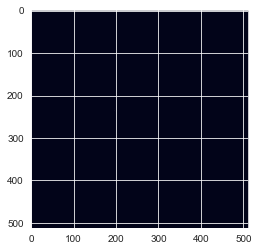

65-81 keV
Correcting dead pixels in raw data
Correcting secondary nan coords: 51120 left
After correction: 0 dead pixels left

Correcting dead pixels in air scan
Correcting secondary nan coords: 71 left
After correction: 0 dead pixels left

Correcting dead pixels in water scan
Correcting secondary nan coords: 71 left
After correction: 0 dead pixels left

Correcting secondary nan coords: 43920 left
After correction: 0 dead pixels left

81-95 keV
Correcting dead pixels in raw data
Correcting secondary nan coords: 54720 left
After correction: 0 dead pixels left

Correcting dead pixels in air scan
Correcting secondary nan coords: 76 left
After correction: 0 dead pixels left

Correcting dead pixels in water scan
Correcting secondary nan coords: 76 left
After correction: 0 dead pixels left

Correcting secondary nan coords: 53280 left
After correction: 0 dead pixels left

Au_phantom K-edge.npy
Starting reconstruction using FDK


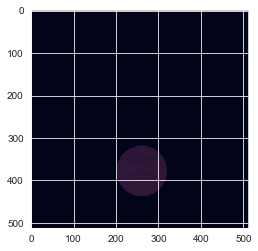

In [1]:
# Obtain the K-edge image for PCD-CT, and normalize to 50 mg/ml

import os
import numpy as np
from reconstruction.ring_corr import devon_correction
from reconstruction.find_dead_pixels import find_dead_pixels
from reconstruction.inidividual_bin_recon import correct_dead_pixels, reconstruct_kedge
from scipy.interpolate import interp1d
from scipy.signal import medfilt
import matplotlib.pyplot as plt

directory = r'\Material_decomposition_data/Calibration_and_test_data'
load_folder = '23_08_26_CT_inserts_PCD'
sub_folders = ['rib2_Au', 'Au_phantom']

thresholds = [30, 35, 50, 65, 81, 95]
recon_bins = [3, 4]

num_angles = 720  # The number of projections
scan_duration = 180
offset = -1

proj_time = scan_duration/num_angles  # The scale factor (the scan time per projection/angle)

# Load the raw flat field, dark field, and water phantom scans (only the first 5 bins, discarding the first frame)
air60 = np.load(os.path.join(directory, load_folder, 'airscan_65s', 'Data', 'data.npy'))[1:, :, :, 0:5]
air1 = np.sum(air60, axis=0) / (60 / proj_time)  # Sum all frames to get the full 60s flat field scan (scaled correctly per frame)
dark = np.load(os.path.join(directory, load_folder, 'darkscan_60s', 'Data', 'data.npy'))[:, :, 0:5]
water = np.load(os.path.join(directory, load_folder, 'water', 'Data', 'data.npy'))[1:, :, :, 0:5]
water = np.sum(water, axis=0)  # Sum all frames

# Go through each sub folder
for sub in sub_folders:

    data = np.load(os.path.join(directory, load_folder, sub, 'Data', 'data.npy'))

     # This will cut the projections down to the correct number if there are more than necessary
    if num_angles != len(data):
        diff = abs(num_angles - len(data))
        data = data[int(np.ceil(diff / 2)):len(data) - diff // 2]

    bin_sinograms = np.zeros((2, *np.shape(data)[0:-1]))

    # Calculate the sinograms for the bins on either side of the K-edge energy
    for bidx, b in enumerate(recon_bins):
        print(f'{thresholds[b]}-{thresholds[b+1]} keV')

        # Sum counts in the correct bins for all data
        bin_data = data[:, :, :, b]
        bin_air1 = air1[:, :, b]
        bin_air60 = air60[:, :, :, b]
        bin_dark = dark[:, :, b]
        bin_water = water[:, :, b]

        # Create the dead pixel mask
        dpm = find_dead_pixels(np.sum(bin_air60[0:6], axis=0), np.sum(bin_air60[6:], axis=0), bin_dark)

        # Correct raw data and air data for dead pixels
        print('Correcting dead pixels in raw data')
        bin_data = correct_dead_pixels(bin_data, dpm, True, False)
        print('Correcting dead pixels in air scan')
        bin_air1 = correct_dead_pixels(bin_air1, dpm, True, True)

        # Do the -ln(I/I0) correction
        bin_sinograms[bidx] = np.squeeze(np.log(bin_air1 + 0.01) - np.log(bin_data + 0.01))

        bin_air1 = np.squeeze(bin_air1)

        # Correct for pixel non-uniformities (ring artifacts)
        corr_array = devon_correction(bin_water, bin_air1 * (60 / proj_time), dpm, num_bins=1)

        # Correct the sinogram
        bin_sinograms[bidx] = np.multiply(corr_array, bin_sinograms[bidx])

        # Additional correction
        sum_corr = np.sum(bin_sinograms[bidx], axis=0)
        sum_dpm = np.ones((24, 576))
        xpts = np.arange(576)
        for z in range(24):
            f = interp1d(xpts, medfilt(sum_corr[z], 21))

            diff = np.abs(f(xpts) - sum_corr[z])

            sum_dpm[z][diff > 10] = np.nan

        bin_sinograms[bidx] = np.squeeze(correct_dead_pixels(bin_sinograms[bidx], sum_dpm, True, False))

    data_low = bin_sinograms[0]
    data_high = bin_sinograms[1]

    os.makedirs(os.path.join(directory, load_folder, sub, 'CT'), exist_ok=True)

    # The save locations for the sinogram, CT, and normalized CT
    save_file = 'K-edge.npy'
    sino_save_path = os.path.join(directory, load_folder, sub, 'Data', save_file)
    ct_save_path = os.path.join(directory, load_folder, sub, 'CT', f'CT_{save_file}')

    print(sub, save_file)
    # Now reconstruct the CT scan
    sino, ct = reconstruct_kedge(data_low, data_high, energies=thresholds[recon_bins[0]:recon_bins[1]+2], h_offset=offset)

    plt.imshow(ct[6], interpolation='nearest', vmin=0.0005, vmax=0.01)
    plt.show()

    np.save(sino_save_path, sino)
    np.save(ct_save_path, ct)


In [1]:
# Normalize the rib K-edge scan

import os
import numpy as np
from reconstruction.inidividual_bin_recon import normalize_kedge

directory = r'\Material_decomposition_data/Calibration_and_test_data'
load_folder = '23_08_26_CT_inserts_PCD'
phantom_subfolder = 'Au_phantom'
rib_subfolder = 'rib2_Au'
norm_slice = 8

os.makedirs(os.path.join(directory, load_folder, rib_subfolder, 'Norm CT'), exist_ok=True)
save_file = 'CT_K-edge.npy'

rib_path = os.path.join(directory, load_folder, rib_subfolder, 'CT', f'{save_file}')
phantom_path = os.path.join(directory, load_folder, phantom_subfolder, 'CT', f'{save_file}')
norm_save_path = os.path.join(directory, load_folder, rib_subfolder, 'Norm CT', f'Norm_{save_file}')

# Load the phantom K-edge CT and the mask of the high concentration location and water location
phantom_ct = np.load(phantom_path)[norm_slice]
contrast_mask = np.load(os.path.join(directory, load_folder, phantom_subfolder, 'contrast_mask.npy'))[0]
water_mask = np.load(os.path.join(directory, load_folder, phantom_subfolder, 'water_mask.npy'))

# Find the normalization values
contrast_value = np.nanmean(phantom_ct * contrast_mask)
water_value = np.nanmean(phantom_ct * water_mask)

# Load the rib K-edge CT
rib_ct = np.load(rib_path)

# Normalize the rib K-edge CT
rib_ct = normalize_kedge(rib_ct, concentration_vals=[contrast_value, water_value])

# Save
np.save(norm_save_path, rib_ct)


Got here
